# Bee-Cycle SQL Project

Bee-Cycle is a bicycle manufacturing company. There are 4 product categories:
- Bikes (eg Touring, Mountain, etc)
- Accessories (eg Helm, Lights, etc)
- Clothing (eg Sock, Jersey, etc)
- Component (eg wheels, pedal etc)

We'll analyze bee-cycle using SQL query. There are 5 tables:
- dim_product = Product information
- dim_customer = Customer information
- dim_territory = Branch store information
- dim_geography = Geography information (related customer address)
- fact_sales = Transaction detail

We'll using database SQL Lite.

## 1. Import Required Libraries and SQL Installation

In [1]:
# Import required libraries
import pandas as pd
import sqlite3

In [2]:
# iPython-sql installation
!pip install ipython-sql

## 2. Load Datasets

In [3]:
# Load all dataframes
df_cust = pd.read_csv('dim_customer.csv')
df_geog = pd.read_csv('dim_geography.csv')
df_prod = pd.read_csv('dim_product.csv')
df_terr = pd.read_csv('dim_territory.csv')
df_sale = pd.read_csv('fact_sales.csv')

## 3. Create New Database

Before we do query, we need to create new database and connect all tables to SQL. The new database will called `database`

In [3]:
# Create connection
conn = sqlite3.connect('database.db')

In [5]:
# Convert all dataframes to table
df_cust.to_sql('dim_customer', conn)
df_geog.to_sql('dim_geography', conn)
df_prod.to_sql('dim_product', conn)
df_terr.to_sql('dim_territory', conn)
df_sale.to_sql('fact_sales', conn)

5954

In [3]:
# Load SQL module to iPython
%load_ext sql

In [4]:
%sql sqlite:///database.db

## 4. Deep Dive Question

Now, we ready to do some query to gain some insights from database. We'll see the relationship of all tables.

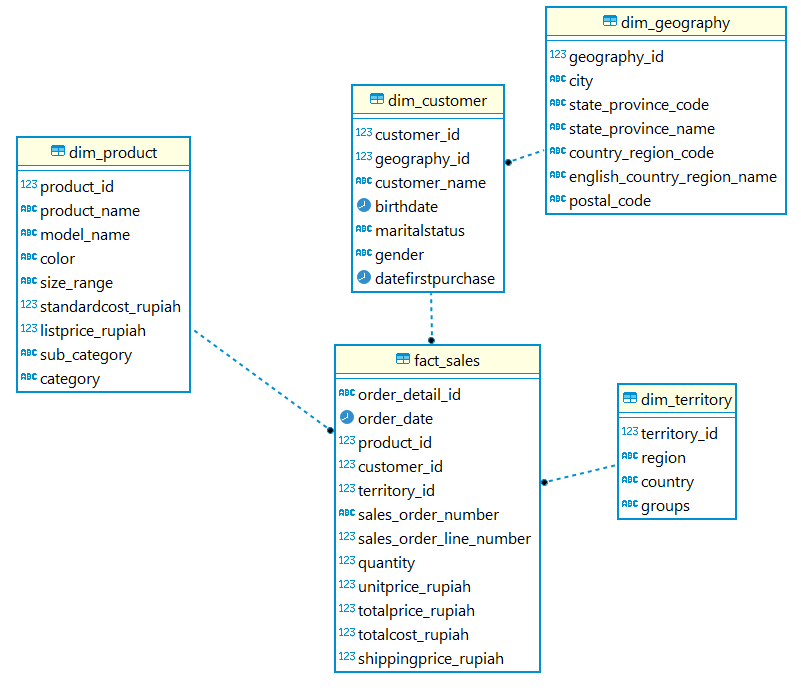

Questions:
1. Top 10 most purchased product
2. Top 10 customer with the biggest purchases
3. Product with the biggest profit
4. Which customers have the first name 'Cameron' (random promotions for customers who have the first name 'Cameron')
5. Profit from each store territory
6. How many profit each year

### **1. Top 10 most purchased product**

In [5]:
%%sql

WITH trans AS (
    SELECT product_id, count(distinct order_detail_id) AS count_ts
    from fact_sales
    GROUP BY 1)

SELECT dp.product_id, dp.product_name, dp.model_name, dp.category, ts.count_ts
FROM dim_product dp LEFT JOIN trans ts ON dp.product_id = ts.product_id
WHERE count_ts is not null
GROUP BY 1,2,3,4,5
ORDER BY count_ts DESC
LIMIT 10

 * sqlite:///database.db
Done.


product_id,product_name,model_name,category,count_ts
477,Water Bottle - 30 oz.,Water Bottle,Accessories,363
480,Patch Kit/8 Patches,Patch kit,Accessories,262
478,Mountain Bottle Cage,Mountain Bottle Cage,Accessories,228
222,"Sport-100 Helmet, Blue",Sport-100,Accessories,221
214,"Sport-100 Helmet, Red",Sport-100,Accessories,201
528,Mountain Tire Tube,Mountain Tire Tube,Accessories,200
537,HL Mountain Tire,HL Mountain Tire,Accessories,199
479,Road Bottle Cage,Road Bottle Cage,Accessories,191
225,AWC Logo Cap,Cycling Cap,Clothing,190
485,Fender Set - Mountain,Fender Set - Mountain,Accessories,188


Accessories become the product category with the most purchased by customers. We can communicate and give advice to product team to improve or develop new innovation to our accessories product. For marketing team, we can give advice to improve the promotion strategy for the improved product.

### **2. Top 10 customer with the biggest purchases**

In [6]:
%%sql

WITH purch AS (
    SELECT customer_id, sum(totalprice_rupiah) AS purchase
    from fact_sales
    GROUP BY 1
    ORDER BY purchase DESC)

SELECT pu.customer_id, dc.customer_name
FROM purch pu LEFT JOIN dim_customer dc ON pu.customer_id = dc.customer_id
WHERE purchase is not null
GROUP BY 1,2
ORDER BY purchase DESC
LIMIT 10

 * sqlite:///database.db
Done.


customer_id,customer_name
12301.0,Nichole Nara
12132.0,Kaitlyn Henderson
12308.0,Margaret He
12131.0,Randall Dominguez
12300.0,Adriana Gonzalez
12321.0,Rosa Hu
12124.0,Brandi Gill
12307.0,Brad She
12296.0,Francisco Sara
13263.0,Kate Anand


We can conclude that these 10 customers are our most loyal customers. It is highly recommended to maintain good relations with these customers, like give them rewards, or discount for certain products.

### **3. Product with the biggest profit**

In [7]:
%%sql

SELECT sub_category,category, round(sum(totalprice_rupiah - totalcost_rupiah),0) AS profit, 
count(order_detail_id) AS Purchase_quantity
from fact_sales fs

LEFT JOIN dim_product dp on fs.product_id = dp.product_id
GROUP BY 1,2
ORDER BY profit DESC
LIMIT 10

 * sqlite:///database.db
Done.


sub_category,category,profit,Purchase_quantity
Mountain Bikes,Bikes,17100271011.0,1113
Road Bikes,Bikes,9813019279.0,670
Touring Bikes,Bikes,4858806716.0,467
Helmets,Accessories,183071125.0,597
Tires and Tubes,Accessories,161341257.0,1254
Bottles and Cages,Accessories,50884924.0,782
Hydration Packs,Accessories,44819657.0,93
Jerseys,Clothing,41678167.0,247
Fenders,Accessories,36215004.0,188
Bike Racks,Accessories,30498720.0,29


Bikes and it's accessories become the product categories with the highest profit. For the product sub category, mountain bikes have the highest profit. We can increase the sales from these category for each branch store to increase the profit.

### **4. Which customers have the first name 'Cameron' (random promotions for customers who have the first name 'Cameron')**

In [8]:
%%sql

SELECT customer_id, customer_name
FROM dim_customer 
WHERE customer_name like 'Cameron%'

 * sqlite:///database.db
Done.


customer_id,customer_name
11301,Cameron Rodriguez
11534,Cameron Lewis
28177,Cameron Henderson
15371,Cameron Bryant
16595,Cameron Anderson


It looks like we have 5 lucky customers with this kind of promotion. We can give these customers an appropriate reward 
because it will potentially increase their loyalty to our products.

### **5. Profit from each store territory**

In [9]:
%%sql

WITH prof AS (
    SELECT territory_id, round(sum(totalprice_rupiah - totalcost_rupiah),0) AS profit
    FROM fact_sales
    GROUP BY 1)

SELECT dt.region, dt.country, pr.profit
FROM dim_territory dt LEFT JOIN prof pr ON dt.territory_id = pr.territory_id
WHERE profit is not null
GROUP BY 3
ORDER BY profit DESC

 * sqlite:///database.db
Done.


region,country,profit
Australia,Australia,11586167905.0
United Kingdom,United Kingdom,4299950829.0
Southwest,United States,4216214768.0
France,France,3842289746.0
Germany,Germany,3820879188.0
Northwest,United States,2771521014.0
Canada,Canada,1867419159.0
Southeast,United States,15469054.0


We can see our branch store in Australia have the biggest profit, meanwhile our branch store in Southeast of United States have the lowest profit. We have to maintain our relationship with our customers in branch store in Australia. For the Southeast of United States branch store, we must do a deep analyze to get the answer why the profit in that area is low, before we do action related this problem.

### **6. How many profit each year month and each month**

In [10]:
%%sql

SELECT strftime('%Y', order_date) as years, 
       strftime('%m', order_date) as month,
       round(sum(totalprice_rupiah - totalcost_rupiah),0) as profit
FROM fact_sales
GROUP BY 1,2

 * sqlite:///database.db
Done.


years,month,profit
2016,07,997090093.0
2016,08,913311819.0
2016,09,776805604.0
2016,10,1086675261.0
2016,11,1368102704.0
2016,12,1600224909.0
2017,01,1172777526.0
2017,02,1293926999.0
2017,03,1745053920.0
2017,04,739188002.0


We can see the high profit were made in the changing months of the year period. It is most likely because our customers get their end of year incentive from their company where they worked. We can increase profit for that period by doing promotion.

## 5. Conclusion

SQL is used to communicate with a database. It is the standard language for relational database management systems (RDBMS).
SQL is a very powerful tool because it is good for creating and managing large databases, which most tech corporations utilize, and also enables you to perform many functions at high efficiency and speed.